In [ ]:
pip install wordcloud


In [ ]:
pip install textblob

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.stem import *
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import textblob
from textblob import TextBlob
import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [5]:
df = pd.read_csv("oscars2023_tweets.csv", sep="|")

## 1. Preprocesing

In [6]:
# Normalizing case
# Here we will turn each tweet to a lowercase representation
df["tweet"] = df["tweet"].str.lower()
#Removing links
df['tweet'] = df['tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
#Removing emojis
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

                Hashtag  Frequency
0               #oscars       1015
1             #oscars95        381
2       #topgunmaverick         63
3       #oscarsluncheon         45
4          #diorcouture         37
..                  ...        ...
436  #leonardodicaprios          1
437         #anadearmas          1
438          #hollywood          1
439               #thr.          1
440          #moonlight          1

[441 rows x 2 columns]

                Username  Frequency
0          @billycrystal        347
1           @chasparnell        347
2    @theacademy#jonhamm        339
3          @marisatomay)         94
4            @theacademy         64
..                   ...        ...
390                 @pbs          1
391        @noolivesthnx          1
392              @kargor          1
393              @sling,          1
394            @saged_up          1

[395 rows x 2 columns]


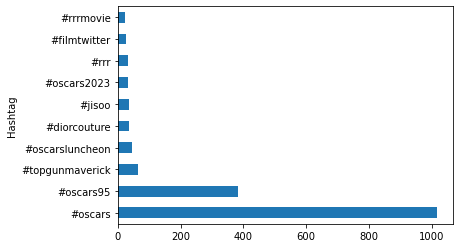

In [7]:
#Obtainign the most frequent hashtags
#Getting the frequency of each word
word_frequency_series = pd.Series(' '.join(df["tweet"]).lower().split()).value_counts()
words_df = pd.DataFrame({'Word':word_frequency_series.index, 'Frequency':word_frequency_series.values})

#Obtaining only the frequency of the hashtags and ats as a dictionary
hashtag_freq_dic = {}
mention_freq_dic = {}
for i in range(len(words_df['Word'])):
    word = words_df['Word'][i]
    if ('@' in word):
        mention_freq_dic[word] =  words_df["Frequency"][i]
    elif('#' in word):
        hashtag_freq_dic[word] =  words_df["Frequency"][i]
hashtag_freq_dic = pd.DataFrame({'Hashtag':pd.Series(hashtag_freq_dic).index, 'Frequency':pd.Series(hashtag_freq_dic).values})
print(hashtag_freq_dic)
print()
mention_freq_dic = pd.DataFrame({'Username':pd.Series(mention_freq_dic).index, 'Frequency':pd.Series(mention_freq_dic).values})
print(mention_freq_dic)

hashtag_freq_dic.head(10).plot.barh(x="Hashtag",legend = None);


In [8]:
# Removing punctuation marks and special characters (including mentions and hashtags)
df["tweet"] = df["tweet"].str.translate(str.maketrans('', '', string.punctuation)) 

## 2. Stemming and data cleaning

In [9]:
# Steeming the data
stemmer = PorterStemmer()
df["tweet"] = df["tweet"].apply(stemmer.stem)
df["tweet"] = df["tweet"].str.lstrip()

In [10]:
# Removing stop words
stop = stopwords.words('english')
df["tweet"] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#Removing unnecesary word (Oscars/Oscar)
df['tweet'] = df['tweet'].str.replace('oscars', '')
df['tweet'] = df['tweet'].str.replace('oscar', '')

## 3. Understanding the text

luncheon     670
host         628
mission      592
teaser       506
95           386
            ... 
moonlight      1
chiron         1
wing           1
teaches        1
stylish        1
Length: 4251, dtype: int64


<AxesSubplot:>

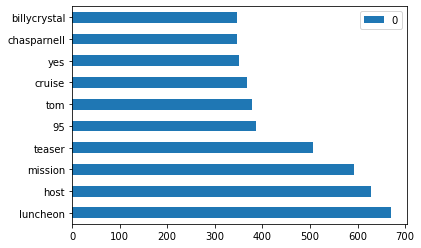

In [11]:
# Most frequent words in the clean dataframe
freq_words = pd.Series(' '.join(df["tweet"]).lower().split()).value_counts()
print(freq_words)
pd.DataFrame(freq_words.head(10)).plot(kind="barh",legend = "Frecuencia")

In [12]:
# Ngrams
tokens = df.tweet.apply(word_tokenize)
ngrams = []
for t in tokens:
    for ng in nltk.ngrams(t, 3):
        ngrams.append(ng)

In [13]:
pd.Series(ngrams).value_counts().head(10)

(mission, host, yes)                              339
(yes, 95, theacademyjonhamm)                      339
(95, theacademyjonhamm, chasparnell)              339
(theacademyjonhamm, chasparnell, billycrystal)    339
(host, yes, 95)                                   339
(top, gun, maverick)                              263
(hamm, charles, parnell)                          252
(jon, hamm, charles)                              252
(charles, parnell, reprising)                     248
(mission, host, first)                            248
dtype: int64

<AxesSubplot:>

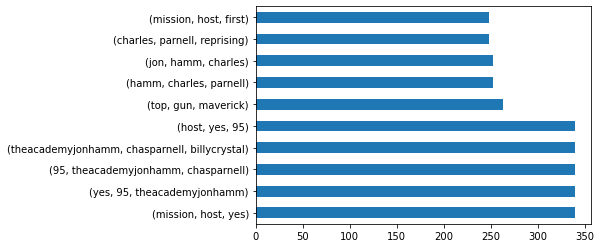

In [14]:
# Plotting the resulting trigrams
pd.DataFrame(pd.Series(ngrams).value_counts().head(10)).plot(kind="barh",legend=None)

## 4. Wordcloud 

In [15]:
# Defining a wordcloud function
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="white",contour_width=3, contour_color='steelblue').generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

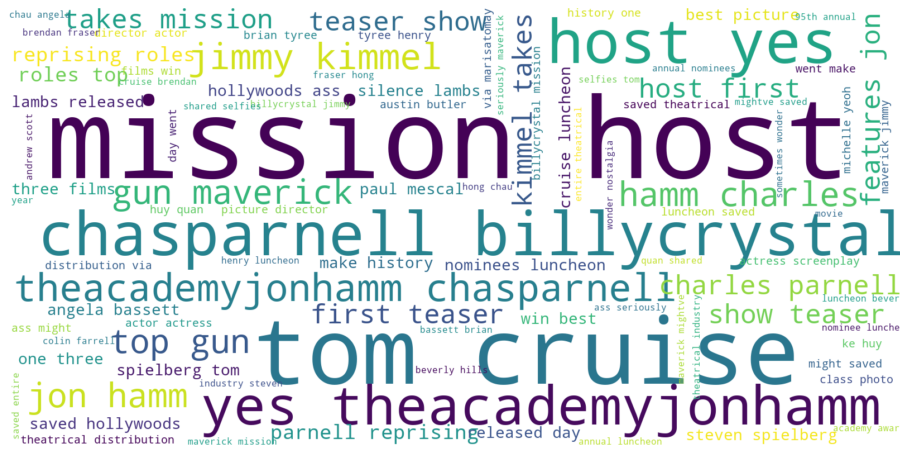

In [16]:
show_wordcloud(df.tweet)

## 5. Sentimental Analysis

In [17]:
def sentimental_analysis(tweet):
    analysis = TextBlob(tweet)
    return np.sign(analysis.sentiment.polarity)

In [18]:
# Adding new column for storing sentimental analysis value
df["sentimental_value"] = ""
df["sentimental_value"]=np.array([sentimental_analysis(tweet) for tweet in df['tweet']])

In [19]:
# Obtaining the ammount of positive, neutral and negative tweets
positive_tweets = [ tweet for index, tweet in enumerate(df['tweet']) if df['sentimental_value'][index] > 0]
neutral_tweets   = [ tweet for index, tweet in enumerate(df['tweet']) if df['sentimental_value'][index] == 0]
negative_tweets = [ tweet for index, tweet in enumerate(df['tweet']) if df['sentimental_value'][index] < 0]

In [20]:
# Obtaining the percentage of each value for further representations
positive_percentage = round((len(positive_tweets)*100)/len(df["tweet"]),2)
neutral_percentage = round((len(neutral_tweets)*100)/len(df["tweet"]),2)
negative_percentage = round((len(negative_tweets)*100)/len(df["tweet"]),2)

<BarContainer object of 3 artists>

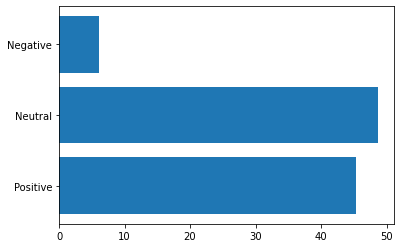

In [21]:
# Plotting the sentimental analysis 
colors = ["#32CD32","yellow","red"]
xlabels = ["Positive","Neutral","Negative"]
ylabels = [positive_percentage,neutral_percentage,negative_percentage]
plt.barh(xlabels,ylabels)

## 6. Topic detection using LDA

In [22]:
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess

In [23]:
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [24]:
data  = df["tweet"].values.tolist()
data_words = list(sentence_to_words(data))

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [26]:
from pprint import pprint

In [27]:
# Training the LDA model

# number of topics
num_topics = 10
# Building the LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
oscars_lda = lda_model[corpus]

[(0,
  '0.036*"luncheon" + 0.016*"host" + 0.015*"mission" + 0.015*"yes" + '
  '0.015*"chasparnell" + 0.015*"billycrystal" + 0.011*"nominees" + '
  '0.011*"cruise" + 0.011*"tom" + 0.010*"photo"'),
 (1,
  '0.025*"chasparnell" + 0.025*"billycrystal" + 0.025*"host" + 0.024*"yes" + '
  '0.024*"mission" + 0.017*"luncheon" + 0.010*"invited" + 0.010*"big" + '
  '0.010*"disney" + 0.010*"sometimes"'),
 (2,
  '0.051*"host" + 0.049*"mission" + 0.042*"yes" + 0.041*"billycrystal" + '
  '0.041*"chasparnell" + 0.014*"teaser" + 0.010*"top" + 0.008*"luncheon" + '
  '0.008*"jimmy" + 0.008*"kimmel"'),
 (3,
  '0.021*"luncheon" + 0.014*"cruise" + 0.014*"tom" + 0.010*"best" + '
  '0.008*"bassett" + 0.008*"angela" + 0.007*"time" + 0.007*"people" + '
  '0.007*"one" + 0.006*"says"'),
 (4,
  '0.044*"saved" + 0.030*"tom" + 0.030*"cruise" + 0.029*"luncheon" + '
  '0.022*"spielberg" + 0.022*"steven" + 0.022*"theatrical" + 0.022*"ass" + '
  '0.022*"hollywoods" + 0.020*"teaser"'),
 (5,
  '0.028*"luncheon" + 0.024*"be

In [ ]:
pip install pyLDAvis

In [29]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

In [ ]:
# Analyzing the LDA model
# Visualizing the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = 'oscars_ldavis'+str(num_topics)

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'oscars_ldavis'+ str(num_topics) +'.html')

LDAvis_prepared

# Top gun maverick sentimental analysis


[44.44, 54.17, 1.39]


<BarContainer object of 3 artists>

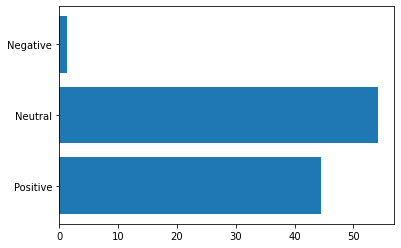

In [31]:
substring1 = 'topgun' or 'top gun' or 'top gun maverick' or 'maverick' or 'topgunmaverick'
df_top_gun = df[df.apply(lambda row: row.astype(str).str.contains(substring1, case=False).any(), axis=1)]


tg_positive_tweets = []
tg_neutral_tweets = []
tg_negative_tweets = []
for index in df_top_gun.index.tolist():
    if df_top_gun['sentimental_value'][index] > 0:
        tg_positive_tweets.append(df_top_gun["tweet"][index])
    elif df_top_gun['sentimental_value'][index] == 0:
        tg_neutral_tweets.append(df_top_gun["tweet"][index])
    else:
        tg_negative_tweets.append(df_top_gun["tweet"][index])
        

tg_positive_percentage = round((len(tg_positive_tweets)*100)/len(df_top_gun["tweet"]),2)
tg_neutral_percentage = round((len(tg_neutral_tweets)*100)/len(df_top_gun["tweet"]),2)
tg_negative_percentage = round((len(tg_negative_tweets)*100)/len(df_top_gun["tweet"]),2)
print([tg_positive_percentage,tg_neutral_percentage,tg_negative_percentage])
# PLOT
xlabels = ["Positive","Neutral","Negative"]
ylabels = [tg_positive_percentage,tg_neutral_percentage,tg_negative_percentage]
plt.barh(xlabels,ylabels)

# Jimmy Kimmel sentimental analysis

<BarContainer object of 3 artists>

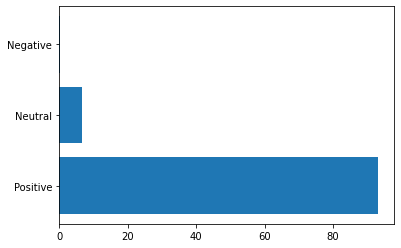

In [32]:
substring2 = 'jimmy' or 'kimmel' or 'jimmy kimmel' or 'host' or 'hosting'
df_jimmy_kimmel = df[df.apply(lambda row: row.astype(str).str.contains(substring2, case=False).any(), axis=1)]


jk_positive_tweets = []
jk_neutral_tweets = []
jk_negative_tweets = []
for index in df_jimmy_kimmel.index.tolist():
    if df_jimmy_kimmel['sentimental_value'][index] > 0:
        jk_positive_tweets.append(df_jimmy_kimmel["tweet"][index])
    elif df_jimmy_kimmel['sentimental_value'][index] == 0:
        jk_neutral_tweets.append(df_jimmy_kimmel["tweet"][index])
    else:
        jk_negative_tweets.append(df_jimmy_kimmel["tweet"][index])

jk_positive_percentage = round((len(jk_positive_tweets)*100)/len(df_jimmy_kimmel["tweet"]),2)
jk_neutral_percentage = round((len(jk_neutral_tweets)*100)/len(df_jimmy_kimmel["tweet"]),2)
jk_negative_percentage = round((len(jk_negative_tweets)*100)/len(df_jimmy_kimmel["tweet"]),2)

# PLOT
xlabels = ["Positive","Neutral","Negative"]
ylabels = [jk_positive_percentage,jk_neutral_percentage,jk_negative_percentage]
plt.barh(xlabels,ylabels)

